In [1]:
%matplotlib inline
import pandas as pd
import sqlite3
from sqlite3 import Error 
from sklearn.datasets import load_wine
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

# Getting the data from database and merging population from other data source

In [2]:
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        print("Connection to SQLite DB successful")
    except Error as e:
        print(f"The error '{e}' occurred")

    return connection

connection = create_connection("twm_banking.sqlite")
customers = pd.read_sql_query("SELECT * FROM customers", connection)

Connection to SQLite DB successful


In [3]:
customers["index_city"] = customers["city_name"]

In [4]:
cities = pd.read_csv("cities.csv", sep = ",")

In [5]:
cities.head()

,index,index_city,Population
0,1,New York City,8175133
1,2,Los Angeles,3971883
2,3,Chicago,2720546
3,4,Brooklyn,2300664
4,5,Houston,2296224


In [6]:
customers.head()

,index,cust_id,income,age,years_with_bank,nbr_children,gender,marital_status,name_prefix,first_name,last_name,street_nbr,street_name,postal_code,city_name,state_code,full_address,full_name,index_city
0,0,1362691,26150,46,5,1,M,2,,Donald,Marek,8298,Second,89194,Las Vegas,NV,8298 Second,Donald Marek,Las Vegas
1,1,1362487,6605,71,1,0,M,2,,ChingDyi,Moussavi,10603,Daffodil,90159,Los Angeles,CA,10603 Daffodil,ChingDyi Moussavi,Los Angeles
2,2,1363160,18548,38,8,0,F,1,,Rosa,Johnston,8817,Figueroa,90024,Los Angeles,CA,8817 Figueroa,Rosa Johnston,Los Angeles
3,3,1362752,47668,54,3,0,F,1,,Lisa,Martin,676,Humble,90172,Los Angeles,CA,676 Humble,Lisa Martin,Los Angeles
4,4,1362548,44554,59,9,2,F,4,,Barbara,O'Malley,6578,C,10138,New York City,NY,6578 C,Barbara O'Malley,New York City


### [source: opendatasoft](https://public.opendatasoft.com/explore/dataset/geonames-all-cities-with-a-population-1000/table/?disjunctive.cou_name_en&sort=name&refine.timezone=America)

In [7]:
customers['index_city'] = customers['index_city'].str.strip()

In [8]:
custumers_pop = customers.merge(cities, how = 'left', on = "index_city")

In [9]:
custumers_pop.shape

(747, 21)

In [10]:
custumers_pop.head()

,index_x,cust_id,income,age,years_with_bank,nbr_children,gender,marital_status,name_prefix,first_name,...,street_nbr,street_name,postal_code,city_name,state_code,full_address,full_name,index_city,index_y,Population
0,0,1362691,26150,46,5,1,M,2,,Donald,...,8298,Second,89194,Las Vegas,NV,8298 Second,Donald Marek,Las Vegas,31,623747
1,1,1362487,6605,71,1,0,M,2,,ChingDyi,...,10603,Daffodil,90159,Los Angeles,CA,10603 Daffodil,ChingDyi Moussavi,Los Angeles,2,3971883
2,2,1363160,18548,38,8,0,F,1,,Rosa,...,8817,Figueroa,90024,Los Angeles,CA,8817 Figueroa,Rosa Johnston,Los Angeles,2,3971883
3,3,1362752,47668,54,3,0,F,1,,Lisa,...,676,Humble,90172,Los Angeles,CA,676 Humble,Lisa Martin,Los Angeles,2,3971883
4,4,1362548,44554,59,9,2,F,4,,Barbara,...,6578,C,10138,New York City,NY,6578 C,Barbara O'Malley,New York City,1,8175133


# Exploratory of the numerical features

In [11]:
custumers_num = custumers_pop[["income", "age", "years_with_bank", "nbr_children", "Population"]]

In [12]:
custumers_num.shape

(747, 5)

In [13]:
custumers_num.head()

,income,age,years_with_bank,nbr_children,Population
0,26150,46,5,1,623747
1,6605,71,1,0,3971883
2,18548,38,8,0,3971883
3,47668,54,3,0,3971883
4,44554,59,9,2,8175133


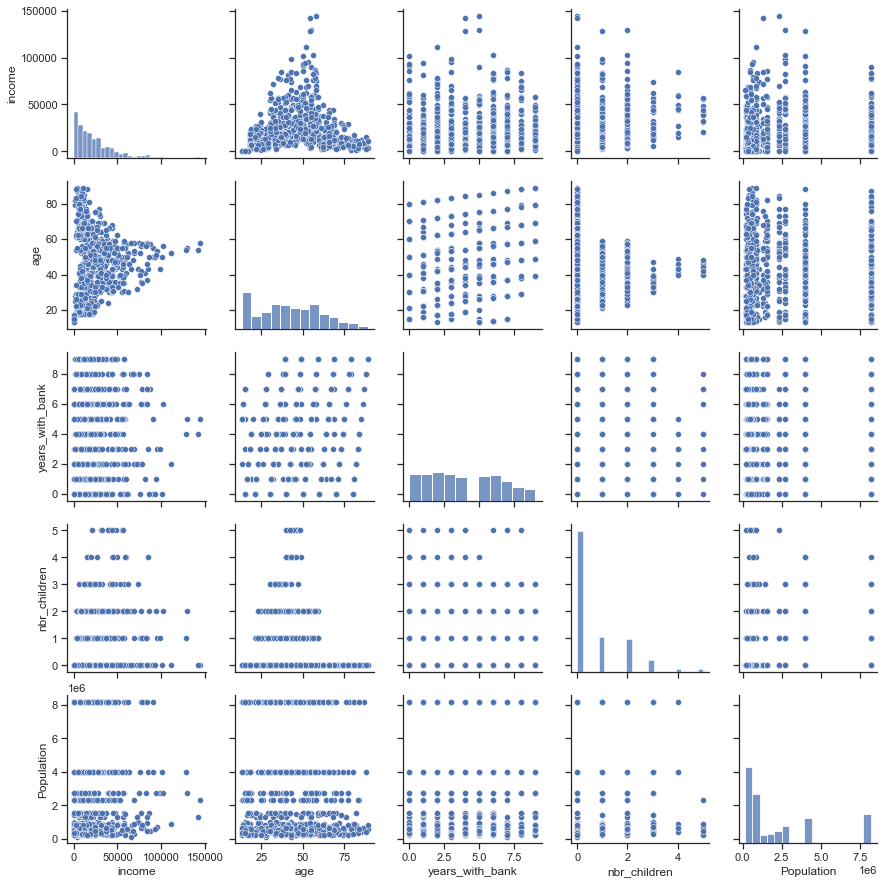

In [14]:
sns.set_theme(style="ticks")
sns.pairplot(custumers_num)

<AxesSubplot:>

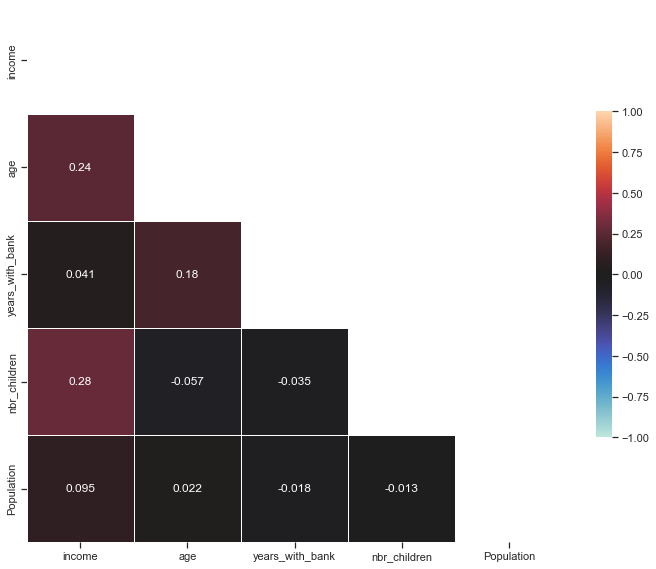

In [15]:
corr = custumers_num.corr()
mask = np.zeros_like(corr, dtype= bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    corr,          # The data to plot
    mask=mask,     # Mask some cells
    annot=True,    # Should the values be plotted in the cells?
    vmax= 1,       # The maximum value of the legend. All higher vals will be same color
    vmin= -1,      # The minimum value of the legend. All lower vals will be same color
    center=0,      # The center value of the legend. With divergent cmap, where white is
    square=True,   # Force cells to be square
    linewidths=.5, # Width of lines that divide cells
    cbar_kws={"shrink": .5}  # Extra kwargs for the legend; in this case, shrink by 50%
)

# Scaling and K-means

In [17]:
scaler = MinMaxScaler(feature_range=(0, 5))
#scaler = StandardScaler()
data_std = scaler.fit_transform(custumers_num)

In [93]:
def plot_distortion(X,max_clusters = 10):
    distortions = []
    for i in range(1, max_clusters +1):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    n_init=10,
                    random_state=0)
        km.fit(X)
        distortions.append(km.inertia_)

    plt.plot(range(1,max_clusters +1), distortions, marker='o', color='black')
    plt.title('Elbow plot - demographics')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show() 

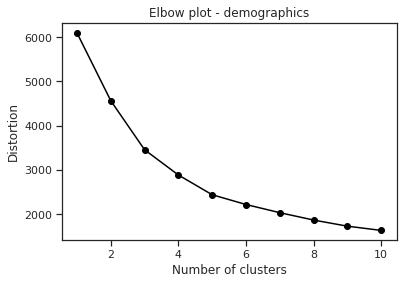

In [94]:
plot_distortion(data_std) # No Elbow! I will call it 4

In [32]:
km = KMeans(n_clusters=3, #number of clusters
           n_init = 10, #how many initial runs
           random_state = 0)

In [33]:
y_km = km.fit_predict(data_std)

In [34]:
groups = pd.DataFrame(y_km)+1
groups.rename(columns = {0:"Group"}, inplace = True)
df_groups = pd.DataFrame(data_std,columns = custumers_num.columns)
df_groups.head()

,income,age,years_with_bank,nbr_children,Population
0,0.906997,2.171053,2.777778,1.0,0.30067
1,0.229091,3.815789,0.555556,0.0,2.38426
2,0.643326,1.644737,4.444444,0.0,2.38426
3,1.653336,2.697368,1.666667,0.0,2.38426
4,1.545329,3.026316,5.000000,2.0,5.00000


In [35]:
df_groups = pd.concat([df_groups,groups], axis = 1)
df_groups.shape

(747, 6)

# Radar Plot

In [23]:
group_mean_df = df_groups.groupby("Group").mean()

In [24]:
import plotly.graph_objects as go
import plotly.offline as pyo

In [25]:
categories = ['Income', 'Age', 'Years with bank', 'Number of children', 'City Population']
# categories = [*categories, categories[0]]

In [26]:
Group_1 = list(group_mean_df.iloc[0,:])
Group_2 = list(group_mean_df.iloc[1,:])
Group_3 = list(group_mean_df.iloc[2,:])
Group_4 = list(group_mean_df.iloc[3,:])
# Group_1 = [*Group_1, Group_1[0]]
# Group_2 = [*Group_2, Group_2[0]]
# Group_3 = [*Group_3, Group_3[0]]
# Group_4 = [*Group_4, Group_4[0]]

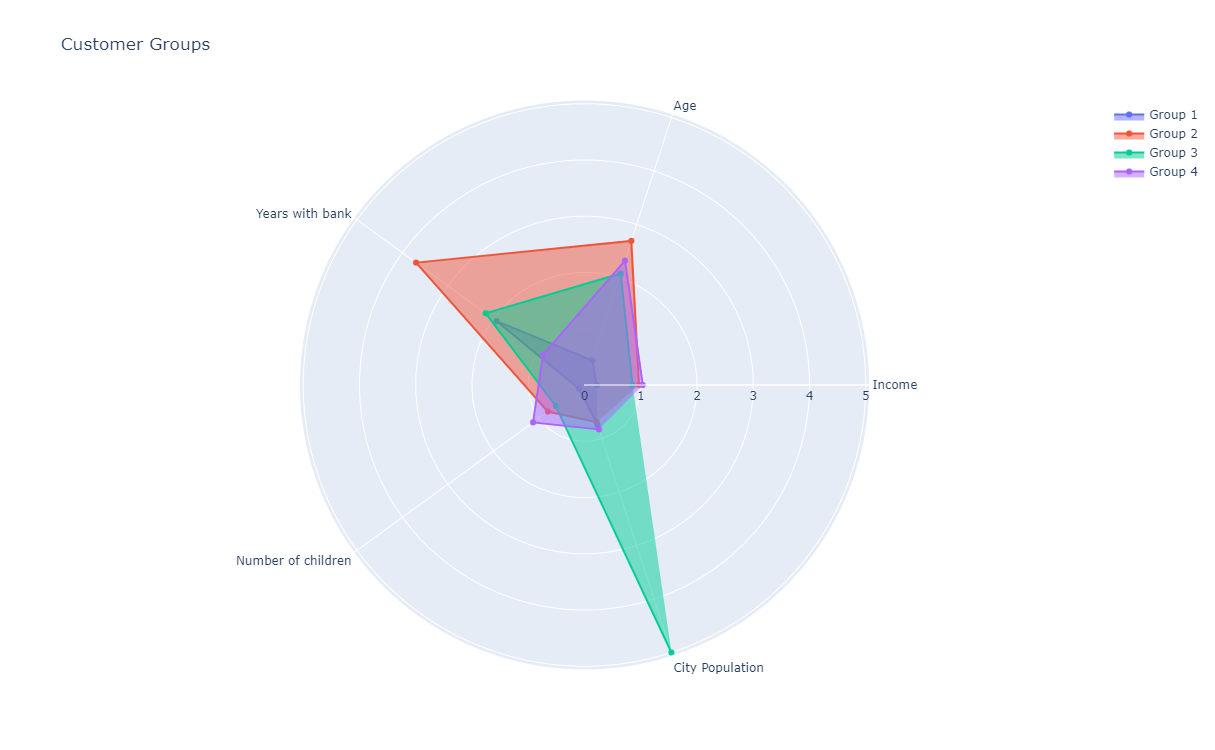

In [38]:
fig = go.Figure(
    data=[
        go.Scatterpolar(r=Group_1, theta=categories, fill='toself', name='Group 1'),
        go.Scatterpolar(r=Group_2, theta=categories, fill='toself', name='Group 2'),
        go.Scatterpolar(r=Group_3, theta=categories, fill='toself', name='Group 3'),
        go.Scatterpolar(r=Group_4, theta=categories, fill='toself', name='Group 4')
    ],
    layout=go.Layout(
        title=go.layout.Title(text='Customer Groups'),
        polar={'radialaxis': {'visible': True}},
        showlegend=True,
        width=750,
        height=750
    )
)

fig.show()
# pyo.plot(fig)

# PCA

In [36]:
n_components = 2
pca = PCA(n_components = n_components)
components = pca.fit_transform(data_std)

In [37]:
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)" for i, var in enumerate(pca.explained_variance_ratio_ *100)
}
labels

{'0': 'PC 1 (31.6%)', '1': 'PC 2 (29.0%)'}

In [38]:
df_PCA = pd.DataFrame(components, columns=[f'PC-{i+1}' for i in range(n_components)], index=custumers_pop.index)

In [39]:
 def plot_clusters(X,y_res, plt_cluster_centers = False):
    X_centroids = []
    Y_centroids = []

    for cluster in set(y_res):
        x = X[y_res == cluster]["PC-1"]
        y = X[y_res == cluster]["PC-2"]
        X_centroids.append(np.mean(x))
        Y_centroids.append(np.mean(y))

        plt.scatter(x,
                    y,
                    s=50,
                    marker='s',
                    label=f'cluster {cluster}')

    if plt_cluster_centers:
        plt.scatter(X_centroids,
                    Y_centroids,
                    marker='*',
                    c='red',
                    s=250,
                    label='centroids')
    plt.title('Principal components - demographics')
    plt.xlabel('PC-2')
    plt.ylabel('PC-1')
    plt.legend()
    plt.grid()
    plt.show()

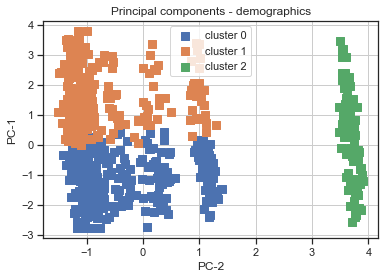

In [40]:
plot_clusters(df_PCA, y_km)

In [43]:
n_components = 3
pca = PCA(n_components = n_components)
components = pca.fit_transform(data_std)

In [44]:
df_PCA = pd.DataFrame(components, columns=[f'PC-{i+1}' for i in range(n_components)], index=custumers_pop.index)

In [45]:
df_PCA

,PC-1,PC-2,PC-3
0,-1.039390,0.590280,0.056808
1,1.213146,-0.624371,2.108275
2,0.886811,2.008368,-1.341466
3,1.181798,0.016792,0.963630
4,3.539962,3.155740,-0.300217
...,...,...,...
742,0.948024,0.882274,-0.990317
743,3.619816,1.581213,0.061363
744,-0.804384,-1.776288,1.744480
745,-1.410914,1.364092,-1.021409


In [46]:

%matplotlib inline
from mpl_toolkits.mplot3d import axes3d   

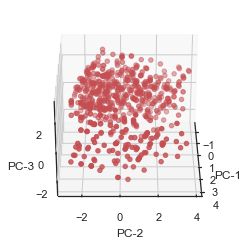

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(df_PCA["PC-1"], df_PCA["PC-2"], df_PCA["PC-3"], c='r', marker='o')

ax.set_xlabel('PC-1')
ax.set_ylabel('PC-2')
ax.set_zlabel('PC-3')
# rotate the axes and update
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

## Stretch work: clustering evolving over iteration from 1 to 20

In [56]:
def plot_clusters_stretch(X,y_res, ax, iteration, plt_cluster_centers = True):
    X_centroids = []
    Y_centroids = []

    for cluster in set(y_res):
        x = X[y_res == cluster]["PC-1"]
        y = X[y_res == cluster]["PC-2"]
        X_centroids.append(np.mean(x))
        Y_centroids.append(np.mean(y))

        ax.scatter(x,
                    y,
                    s=50,
                    marker='o',
                    label=f'cluster {cluster}')

    if plt_cluster_centers:
        ax.scatter(X_centroids,
                    Y_centroids,
                    marker='*',
                    c='red',
                    s=250,
                    label='centroids')
    ax.set_title(f'PCA scatter-demographics(iteration: {iteration})')
    ax.set_xlabel('PC-2')
    ax.set_ylabel('PC-1')
    ax.legend(bbox_to_anchor=(0.6, 0.8))
    ax.grid()

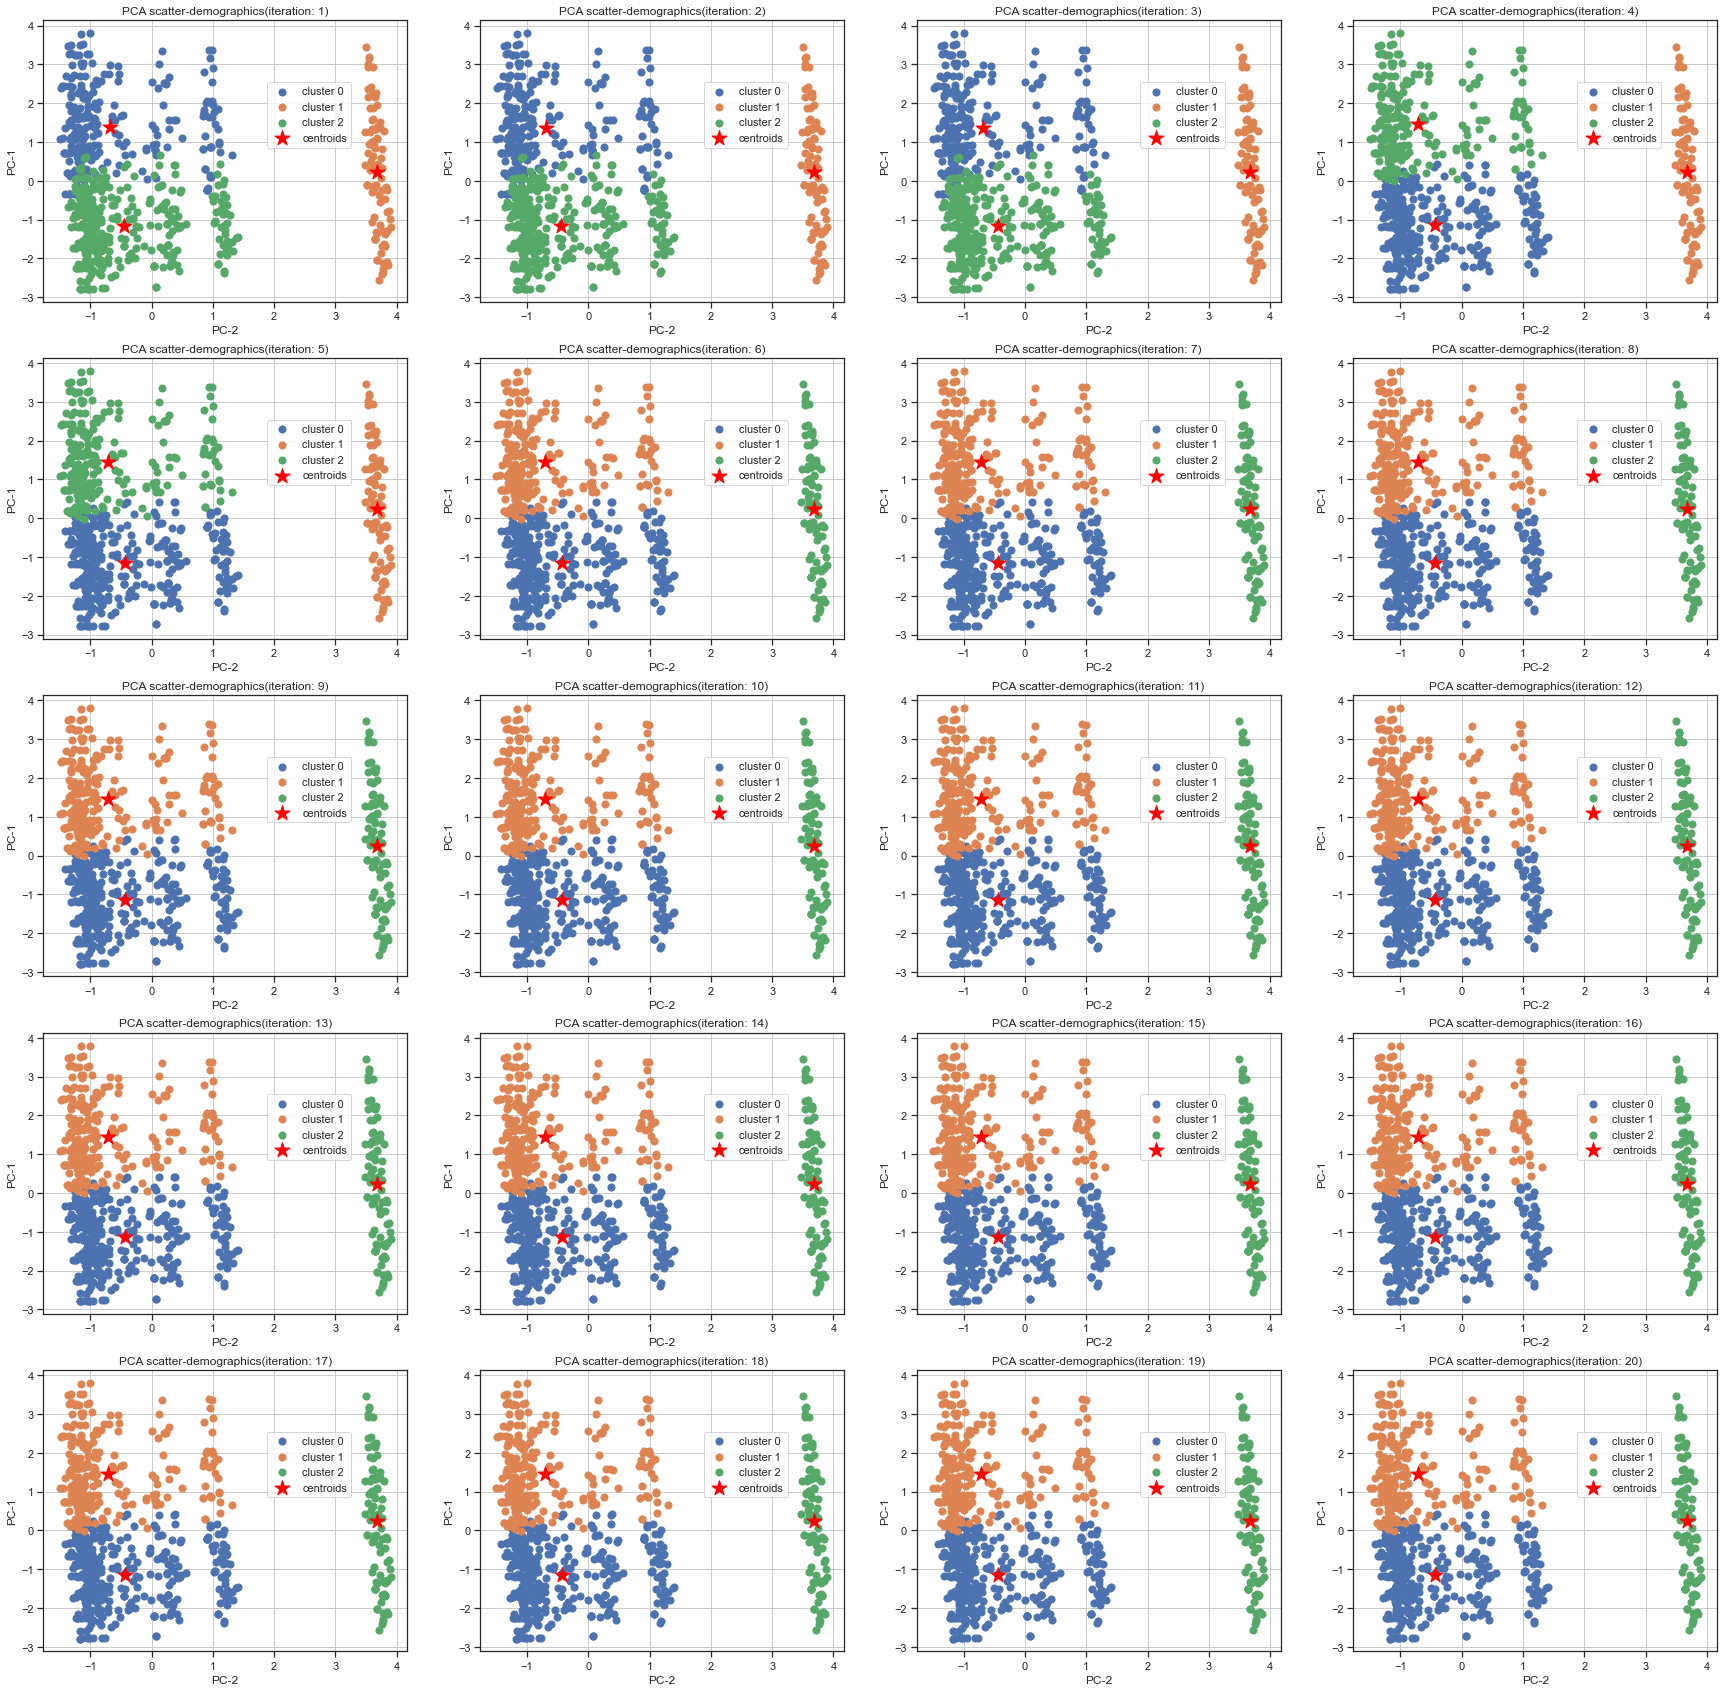

In [60]:
fig, ax = plt.subplots(figsize=(30, 30), nrows=5, ncols=4)
i, j = 0, 0

for iteration in range(1, 21):
    km = KMeans(
        n_clusters=3,
        max_iter=iteration,
        random_state=0
    )
    y_km = km.fit_predict(data_std)
    
    plot_clusters_stretch(df_PCA, y_km, ax[i,j], iteration)
    
    if j == 3:
        i += 1
        j = 0
    else:
        j += 1

fig.savefig('Demographics_iter1-20')